In [6]:
import logging
import time
import xarray as xr
import glob
import pandas as pd

from matplotlib import pyplot as plt
from tqdm import tqdm

In [7]:
from examples.download_kernels import download_kernels
from src.config import ShSpOpt
from src.shadowspy.data_handling import fetch_and_process_data
from src.shadowspy.dem_processing import prepare_dem_mesh
from src.shadowspy.helpers import setup_directories, process_data_list
from src.shadowspy.raster_products import basic_raster_stats
from src.shadowspy.utilities import run_log

Setup config and directories

In [8]:
opt = ShSpOpt()
opt.setup_config(config_file='MoonSP_config.yaml')
opt.set(siteid='MoonSPsmall')
opt.display()

setup_directories(opt)

### ShSpOpt.siteid updated to MoonSPsmall.
initialized = True
siteid = MoonSPsmall
Fsun = 1361
flux_path = None
wavelength = None
Rb = 1737.4
base_resolution = 40
config_file = None
download_kernels = False
max_extension = 200e3
extres = {'20e3': 80, '60e3': 120, '100e3': 240, '300e3': 480}
lonlat0_stereo = [0, -90]
bbox_roi = ['-10e3', '-10e3', '-5e3', '-5e3']
shapefile_roi = None
mesh_ext = .vtk
epos_utc = []
start_time = 2026-01-30 15:00:00.0
end_time = 2026-01-30 17:00:00.0
time_step_hours = 1
azi_ele_path = None
images_index = None
point_source = True
source = SUN
extsource_coord = ./aux/coordflux_100pts_outline33_centerlast_R1_F1_stdlimbdark.txt
root = ./
indir = ./aux/
dem_path = /home/sberton2/Lavoro/projects/validate_shadowspy/LDEM_80S_40MPP_ADJ.TIF
fartopo_path = same_dem
outdir = ./out/
tmpdir = ./tmp/


download kernels

In [4]:
if opt.download_kernels:
    download_kernels()

prepare mesh of the input dem

In [10]:
start = time.time()
logging.info(f"- Computing trimesh for {opt.dem_path}...")
inner_mesh_path, outer_mesh_path, dem_path = prepare_dem_mesh(opt.dem_path, opt.tmpdir, opt.siteid, opt)
logging.info(f"- Meshes generated after {round(time.time() - start, 2)} seconds.")

INFO:root:- Computing trimesh for /home/sberton2/Lavoro/projects/validate_shadowspy/LDEM_80S_40MPP_ADJ.TIF...
INFO:root:Clipped /home/sberton2/Lavoro/projects/validate_shadowspy/LDEM_80S_40MPP_ADJ.TIF to -10e3_-10e3_-5e3_-5e3 and saved to ./tmp/clipped_dem_MoonSPsmall_-10e3_-10e3_-5e3_-5e3.tif
INFO:root:- Meshes generated after 7.17 seconds.


- Delauney mesh computed and saved to ./tmp/MoonSPsmall_b40_dn1_st.vtk.
- Delauney mesh computed and saved to ./tmp/MoonSPsmall_b40_dn1.vtk.


Determine the mode and prepare data list

In [11]:
data_list, use_azi_ele, use_image_times = fetch_and_process_data(opt)
logging.info(f"- Illuminating input DEM at {data_list}.")

INFO:root:- Illuminating input DEM at ['2026-01-30 15:00:00.000000', '2026-01-30 16:00:00.000000', '2026-01-30 17:00:00.000000'].


Common arguments for both cases

In [12]:
common_args = {
    'meshes': {'stereo': f"{inner_mesh_path}_st{opt.mesh_ext}", 'cart': f"{inner_mesh_path}{opt.mesh_ext}"},
    'basemesh_path': outer_mesh_path + opt.mesh_ext,
    'path_to_furnsh': f"{opt.indir}simple.furnsh",
    'point': opt.point_source,
    'extsource_coord': opt.extsource_coord,
    'source': opt.source,
    'dem_path': dem_path,
}

actually compute irradiance at each element of data_list

In [8]:
dsi_epo_path_dict = process_data_list(data_list, common_args, use_azi_ele, use_image_times, opt)

  0%|          | 0/3 [00:00<?, ?it/s]/home/sberton2/Lavoro/code/shadowspy/src/shadowspy/shape.py:70: RuntimeWarning: invalid value encountered in divide
  vertex_normals /= vertex_triangle_counts[:, np.newaxis]
 33%|███▎      | 1/3 [00:05<00:11,  5.70s/it]/home/sberton2/Lavoro/code/shadowspy/src/shadowspy/shape.py:70: RuntimeWarning: invalid value encountered in divide
  vertex_normals /= vertex_triangle_counts[:, np.newaxis]
 67%|██████▋   | 2/3 [00:11<00:05,  5.52s/it]/home/sberton2/Lavoro/code/shadowspy/src/shadowspy/shape.py:70: RuntimeWarning: invalid value encountered in divide
  vertex_normals /= vertex_triangle_counts[:, np.newaxis]
100%|██████████| 3/3 [00:16<00:00,  5.55s/it]


3it [00:00, 47.42it/s]


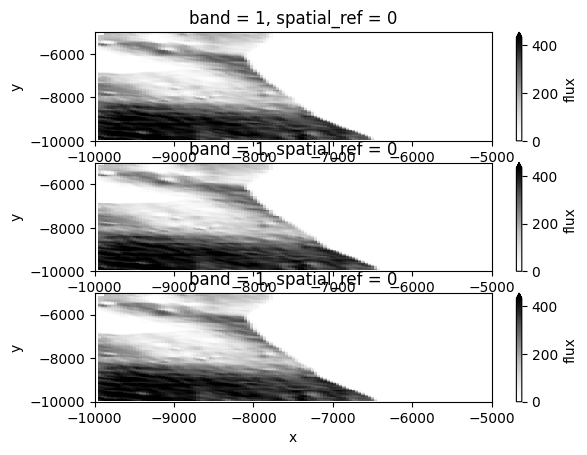

In [14]:
render_paths = glob.glob(f"{opt.outdir}{opt.siteid}/{opt.siteid}_*.tif")[:]
pd.DataFrame.from_records([dsi_epo_path_dict], header=None).T.to_csv(f'{opt.outdir}{opt.siteid}/dsi_epo_paths.csv')

fig, axes = plt.subplots(nrows=len(render_paths), ncols=1)
for idx, render in tqdm(enumerate(render_paths)):
    da = xr.open_dataarray(render)
    # da = da.sel(band=1).coarsen({'x': 3, 'y': 3}, boundary='trim').mean() 
    da.plot(robust=True, cmap='Greys', ax=axes[idx])

plt.show()

prepare mean, sum, max stats rasters and set-up log file

100%|██████████| 3/3 [00:00<00:00, 115.06it/s]
INFO:root:- Cumulative flux saved to ./out/MoonSPsmall_sum_260130150000_260130170000.tif.
INFO:root:- Maximum flux saved to ./out/MoonSPsmall_max_260130150000_260130170000.tif.
INFO:root:- Average flux saved to ./out/MoonSPsmall_mean_260130150000_260130170000.tif.


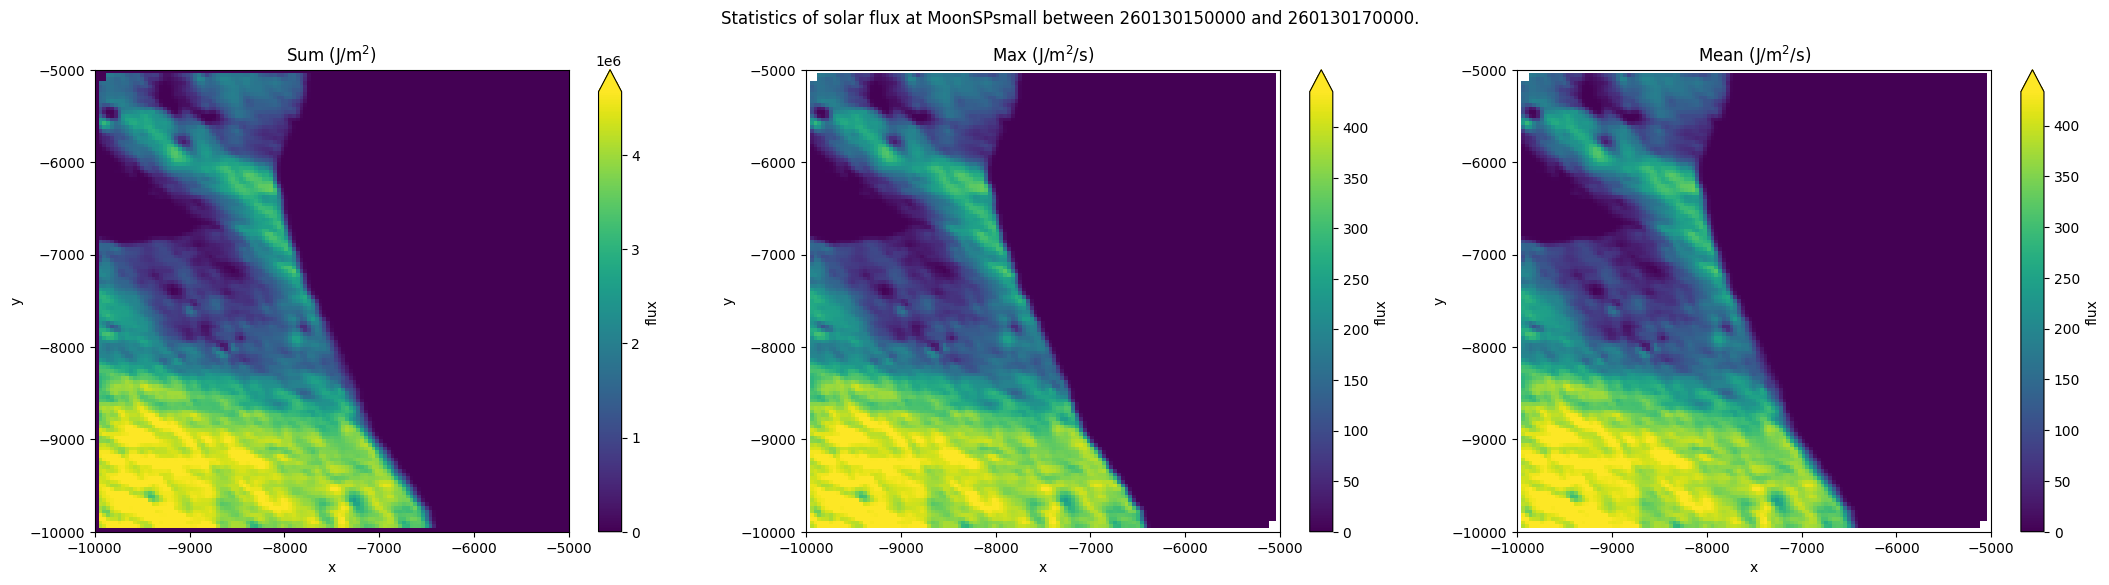

In [13]:
# from datetime import datetime

dsi_epo_path = pd.read_csv(f'{opt.outdir}{opt.siteid}/dsi_epo_paths.csv').set_index('Unnamed: 0').to_dict()['0']
# dsi_epo_path = {datetime.strptime(str(k), '%Y%m%d%H%M%S'):v for k,v in dsi_epo_path.items()}
dem = xr.open_dataarray(common_args['dem_path'])
basic_raster_stats(dsi_epo_path, opt.time_step_hours, crs=dem.rio.crs, outdir=opt.outdir, siteid=opt.siteid)

In [15]:
run_log(Fsun=opt.Fsun, Rb=opt.Rb, base_resolution=opt.base_resolution, siteid=opt.siteid, dem_path=dem_path, outdir=opt.outdir,
        start_time=opt.start_time, end_time=opt.end_time, time_step_hours=opt.time_step_hours,
        runtime_sec=round(time.time() - start, 2), logpath=f"{opt.outdir}{opt.siteid}/illum_stats_{opt.siteid}_{int(time.time())}.json")
logging.info(f"Completed in {round(time.time() - start, 2)} seconds.")

INFO:root:Completed in 102.97 seconds.
